# Lab 3
### Machine Learning

In this lab, we will explore k-Nearest Neighbors (k-NN) classification and Logistic Regression with Gradient Descent, implementing both models manually to gain an understanding of how they work.

As always we start by importing the important libararies we will need. Note here we have both random and from collections import counter, both of these are modules included in python itself, but we need to load them explicitly as we would other imported packages.

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt

#set random seed
random.seed(42)

# This Weeks Dataset: The "Census Income" dataset.

We are going to focus on the 'Census Income' dataset, from https://archive.ics.uci.edu/dataset/2/adult.

The dataset contains demographic and income-related information. The task is to predict whether an individual's income exceeds $50K per year. This is a binary classification problem where the target variable has two possible values: '>50K' and '<=50K'.

There are quite a few ways to load in datasets. In this case, because the dataset is available online we can load it in directly using it's url, as shown below (internet access is needed for this):

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
data = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)

You'll see that whereas last time we imported a csv with ';' as the seperator, this time the file is a .data file, and we manually set column names and tell pandas to read ? values as NA. In general there is no universal rule for how we read in datasets, often it is best to consult the documentation, check code from others who have worked with the same dataset or just try importing, printing and adjusting. 

Use some of the functions we have learned or new ones to look at the data:

In [3]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


<Axes: >

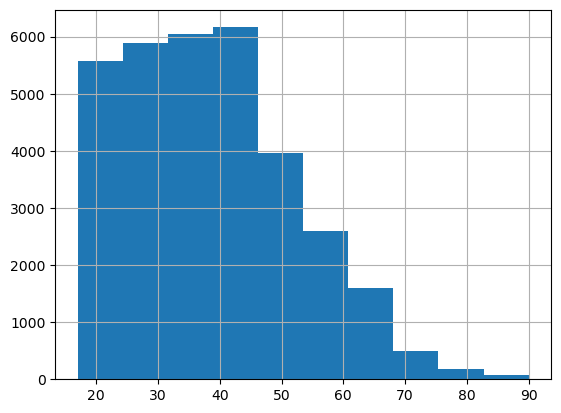

In [11]:
data['age'].hist(bins= 10)

In [9]:
col_names = data.columns
print(col_names)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')


Let's look at the missing values in the dataset.

In [12]:
missing_values = data.isnull().sum()
print(missing_values)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


Once again we don't have any, let's enjoy this while it lasts!

For our binary classification tasks we need numerical labels, so lets convert the income category to be binary, one if it is '>50K', and 0 if it is '<=50K'.

For this we use the very useful .apply() function which applies a specified function to the rows given. Then we can use use lambda which is a way to define a function in one line. The whole method looks like this: .apply(lambda x: 1 if x == '>50K' else 0). Use this on the 'income' category.

In [14]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

We also want to only focus on the numerical features for our applications. We define X and Y as such:

In [16]:
# Select relevant numerical features for classification.
X = data[['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']]
y = data['income']

Now we will split the data into test and training sets, with the addition of the validation set.

 The validation set is what we will use to tune our hyperparameters. It is important we do not use the testing set for this as otherwise we will pick a model due to its strong performance on the testing set and thereby bias or testing error to be lower than it would otherwise be. The test set should stay untouched until the end of our proceedure when we use it to calculate the error!

 Split your training data twice using train_test_split function first into test and training sets, and then further split the training set into training and validation sets. Use a 60/20/20 split for training/validation/testing.

 You should end up with 6 dataframes: X_train, X_test, y_train, y_test, X_val and y_val.

In [18]:
seed = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed) 

print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(32561, 5)
(32561,)
(19536, 5)
(19536,)
(6513, 5)
(6513,)
(6512, 5)
(6512,)


#### Standardisation
As we have done before we standardise the data. This helps in improving the performance of models, and is especially important for distance-based methods like k-NN. Remember to fit on the trainnig set and then use this transformation for both validation and testing set.

In [19]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

### Taking a subset

As our dataset is very large and our naive implementation of knn is quite computationally expensive, we will create a random subset of the validation set for validation.

In [20]:
X_val_subset = random.sample(list(X_val), 100)
y_val_subset = random.sample(list(y_val), 100)

# K Nearest Neighbours

Now we are going to implement the k nearest neighbours algorithm we saw in class.

The k-NN algorithm classifies a new data point based on the majority label among its k nearest neighbors. It calculates the distance between the test point and all training points, selects the k closest ones, and assigns the most frequent class label among them.

It helps to first define our distance measure as a function:

In [21]:
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

Now see if you can implement a knn_predict() function which takes the training set, a test (or validation) set, the training labels and the value of k as input and returns the predicted labels for the test (or validation) set.

Hint: here is two lines of code which, if given the indices of the k nearest neighbours will return their most common labels:

`k_nearest_labels = [y_train.iloc[i] for i in k_indices] # We get the labels of the k nearest neighbors.`

`most_common = Counter(k_nearest_labels).most_common(1)[0][0] # We get the most common class label.`

In [24]:
def knn_predict(X_train, y_train, X_test, k=5):
    predictions = []
    for test_point in X_test: 
        distances = [euclidean_distance(test_point, train_point) for train_point in X_train] 
        k_indices = np.argsort(distances)[:k] 
        k_nearest_labels = [y_train.iloc[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)[0][0] 
        predictions.append(most_common)
    return np.array(predictions)


Run the function you created on the training data and X_val_subset from above, and then calculate the accuracy of the predicitons, i.e. where your predicted values == X_val_subset. Print this value, and then compute the confusion matrix using the confusion_matrix() function.

Note: This code might take a while to run, but if you are getting times above 2 minutes or so something is probably wrong.

In [25]:
y_pred_knn = knn_predict(X_train, y_train, X_val_subset, k=5)
k_nn_accuracy = np.mean(y_pred_knn == y_val_subset)
print(k_nn_accuracy)
confusion_matrix(y_val_subset, y_pred_knn)


0.65


array([[59, 16],
       [19,  6]])

Luckily we don't have to do things with manual implementation! Sklearn has a much more efficient implementation of the KNN classifier. Here we again see the basic structure of fitting models, where we first define the model as an object, then fit it to the data and finally use it to predict over the test (or in this case validation) set.

In [26]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)
y_pred_sklearn_knn = knn.predict(X_val_subset)
sklearn_accuracy = np.mean(y_pred_sklearn_knn == y_val_subset)
print(f'Scikit-learn k-NN Accuracy: {sklearn_accuracy:.2f}')
confusion_matrix(y_val_subset, y_pred_sklearn_knn)

Scikit-learn k-NN Accuracy: 0.62


array([[56, 19],
       [19,  6]])

Can you use the code above to create a graph of the accuracy of the k-NN classifier for different values of k from 1 to 10?

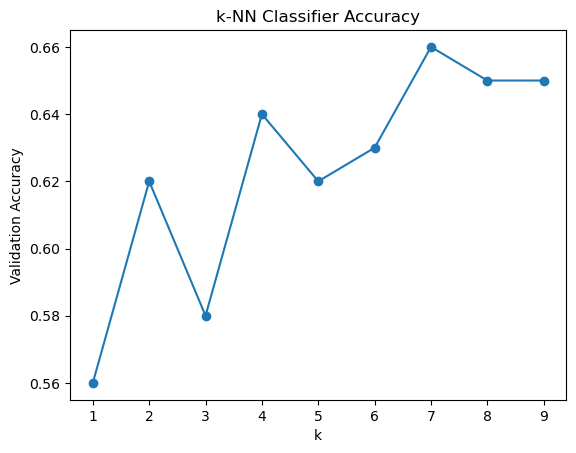

In [27]:
k_values = range(1, 10)
accuracies = []
for k in k_values:
    knn_model = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_val_subset)
    accuracy = np.mean(y_pred_knn == y_val_subset)
    accuracies.append(accuracy)
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title('k-NN Classifier Accuracy')
plt.show()

# Gradient Descent and Logistic Regression

Logistic regression is a statistical model for binary classification. Unlike linear regression, which predicts continuous values, logistic regression predicts probabilities. Central to the model is the sigmoid function which ensures outputs fall between 0 and 1. 

As logistic regression has no closed form solution (unlike simple linear regression from last week), to train it we need to use gradient descent on the log-loss function (which is specifically called the Binary Cross-Entropy Function when applied to binary classification tasks).

We were already introduced to the learning rate in the lectures, which controlls the size of the step, but another important hyperparameter for gradient descent is the number of epochs. This is basically how many steps the gradient descent algorithm should take before it stops. Of course ideally our gradient descent process would converge at a global minimum, and we could simply stop there, but in practice this rarely happens, especially with complex models and as such is best to always set a limit on epochs. Convergence can then be judged by the plotting the loss.

Implementing gradient descent by hand is quite complex, so I have given some example code where you can fill in the code where I have left comments. If you feel very comfortable in python feel free to try to implement it from scratch.

#### **Hints for Implementing Gradient Descent in Logistic Regression**

**1. Compute Linear Combination**
$$
z = X \theta
$$
- Use `np.dot()` to compute the dot product.

**2. Apply Sigmoid Function**
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

**3. Compute Gradient**
$$
\nabla J(\theta) = \frac{1}{m} X^T (y_{\text{pred}} - y)
$$

**4. Update Parameters**
$$
\theta = \theta - \alpha \nabla J(\theta)
$$

**5. Compute Loss**
$$
J(\theta) = -\frac{1}{m} \sum \left[ y \log(y_{\text{pred}}) + (1 - y) \log(1 - y_{\text{pred}}) \right]
$$


#### Implementing Gradient Descent:

First we will define a function for the sigmoid and our cross-entropy loss. Then we implement the gradient descent algorithm. The function should return the parameters theta, the bias therm and the losses at each epoch.

In [34]:
# The sigmoid function transforms any real number into a probability value between 0 and 1.
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Log-loss function (Binary Cross-Entropy):
# It measures how well the predicted probabilities align with the actual labels.
def compute_loss(y, y_pred):
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

In [35]:
def gradient_descent(X, y, lr=0.01, epochs=2000):
    m, n = X.shape # m = number of samples, n = number of features
    theta = np.zeros(n)  # Initialize parameters with zeros
    losses = [] # Initialize loss history

    for epoch in range(epochs): # Loop over the number of epochs
        linear_model = np.dot(X, theta)  # Compute linear combination
        y_pred = sigmoid(linear_model)  # Apply sigmoid function

        gradient = np.dot(X.T, (y_pred - y)) / m  # Compute gradient
        theta -= lr * gradient  # Update all parameters (including bias)

        loss = compute_loss(y, y_pred) # Calculate loss
        losses.append(loss) # Save the loss at each epoch

        if epoch % 500 == 0: # Print the loss every 500 epochs
            print(f'Epoch {epoch}, Loss: {loss:.4f}')

    return theta, losses # Return the learned parameters and the loss history

Lets test if our gradient descent algorithm worked.

Epoch 0, Loss: 0.6931
Epoch 500, Loss: 0.4720
Epoch 1000, Loss: 0.4367
Epoch 1500, Loss: 0.4253


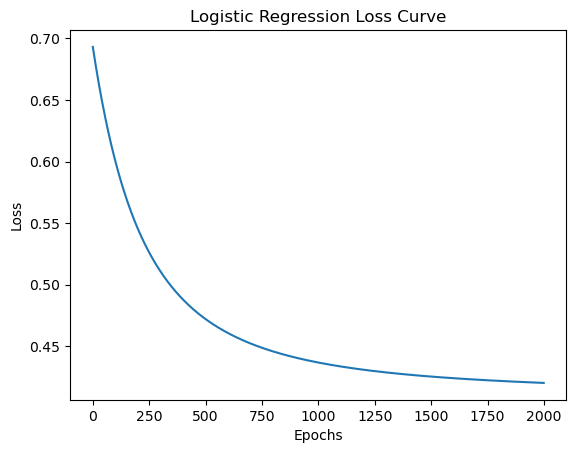

In [36]:
# Prepare the training data for logistic regression by adding a bias term.
X_train_log = np.c_[np.ones(X_train.shape[0]), X_train]

# Train logistic regression using gradient descent.
theta, losses = gradient_descent(X_train_log, y_train.values, lr=0.01, epochs=2000)

# Plot loss curve to observe convergence behavior.
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Logistic Regression Loss Curve")
plt.show()

Now we have the same code again, but I want you to play around with different values for the learning rate and number of epochs. These are two very important parameters in general, but especially for neural network models so it is good to have an intuitive feeling for them and how they affect convergence.

In [33]:
# Train logistic regression using gradient descent.
theta, losses = gradient_descent(X_train_log, y_train.values, lr=0.01, epochs=2000)

# Plot loss curve to observe convergence behavior.
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Logistic Regression Loss Curve")
plt.show()

TypeError: 'numpy.ndarray' object is not callable

Finally we create a function that takes the parameters 'theta' from our output and calculates the predicted values. To do this it calculates the the linear model for the X values, then runs the results through the sigmoid function to transform them into probabilities, and finally it assigns 1 to all points with a probability over the classification threshold and 0 to all points below it.

0.5 is usually used as a claffification threshold but it doesn't have to be, other values can give a more optimum combination of false positives and negatives.

In [ ]:
#print logistic regression accuracy
def predict(X, theta, classification_threshold=0.5):
    linear_model = np.dot(X, theta)
    y_pred = sigmoid(linear_model)
    return (y_pred >= classification_threshold).astype(int)

X_val_log = np.c_[np.ones(X_val.shape[0]), X_val]
y_pred_log = predict(X_val_log, theta, classification_threshold=0.5)
logistic_accuracy = np.mean(y_pred_log == y_val)
print(f'Logistic Regression Accuracy: {logistic_accuracy:.2f}')

confusion_matrix(y_val, y_pred_log)

#### Using Sklearn

It is good to know we can use sklearn to do the same thing with much much less code!

Note: We don't need to set epochs or learning rate here because sklearn natively uses adaptive and optimized versions of gradient descent which employs second order derivatives and other techniques to converge faster and more accurately. As logistic regression is relatively simpler than other ML methods these algorithms simply run until convergence and will give an error if convergence is not reached.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_sklearn = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_sklearn)
print(f'Logistic Regression Accuracy (Sklearn): {accuracy:.2f}')
confusion_matrix(y_val, y_pred_sklearn)

From the validation set accuracy, sklearns implementation of logistic regression seems to be the best model. Therefore we fit it on the training and validation data together to use all available data and test it on the test set to get an idea of its generalisation performance.

In [ ]:
#These two lines recombine the training and validation sets to train the model on the full training set:
X_train_full = np.concatenate((X_train, X_val), axis=0)
y_train_full = np.concatenate((y_train, y_val), axis=0)


# Run the model again here and print the accuracy

Bonus: Create a graph which plots the accuracy of the logistic regression classifier for different values of the classification threshold.